For the analysis I selected the following ETF, each of which tracking a corresponding index. 

-> SPY = tracking SP500

-> QQQ = tracking Nasdaq

-> DIA = tracking Dow Jones 

-> IWM = tracking Russel 2000

-> FEZ = tracking EUROSTOXX50

The choice of using ETFs for my analysis is due to the impossibility of fetching the whole indexes via TwelveData free API. Nonetheless, this choice represents a valid and feasible alternative due to the importance of the ETF, their fidelty to the indexes price variations, and their high liquidity, making them ideal trading instruments, especially for intraday movements.

In [ ]:
import pandas as pd
from twelvedata import TDClient 
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import skew
import time


In [ ]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Access the API key
api_key = os.getenv("API_KEY")

td = TDClient(apikey=api_key)

td = TDClient(apikey=api_key)

In [4]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
ETFs= ['SPY','QQQ','DIA','IWM','FEZ']
INDEXs= ['SP500', 'Nasdaq', 'DowJones', 'Russel2000','EuroStoxx']

Following, a list of the main events that influenced the US elections, which I'll eventually highlight to see if and how they affected the market behaviour.


In [6]:
# Define the list of events with corresponding date and time
events = {
    "2020-03-19": "First Statal Covid lockdown",
    "2020-11-03": "Joe Biden elected",
    "2021-01-06": "Capitol Hill riot",
    "2022-02-24": "Ukraine invasion",
    "2022-06-10": "inflation 40-year high",
    "2022-11-08": "Republicans win mid-term",
    "2023-03-10": "SVBank collapse",
    "2023-10-07": "Israel-Hamas conflict",
    "2024-05-01": "FED pauses rate hikes",
    "2024-07-13": "Trump attempted shooting",
    "2024-07-22": "Biden resignment",
    "2024-11-05": "Election date",
    "2024-11-06": "Election results",
    "2024-11-06 05:20:00": "North Carolina results",
    "2024-11-06 06:14:00": "Republicans win senate",
    "2024-11-06 06:42:00": "Georgia results",
    "2024-11-06 08:10:00": "Pennsylvania results",
    "2024-11-06 11:36:00": "Winconsin results",
    "2024-11-06 11:42:00": "Presidency victory",
    "2024-11-06 19:05:00": "Michigan results",
    "2024-11-07 04:06:00": "Xi Jinping congrats"
}


Now I'll define all the functions used in the first part of the analysis

In [7]:
#function to retrieve historical data for the given ticker  
def data_retrieval (ticker , frequency , startdate, enddate):
    """
    Retrieve historical time series data for a given ticker from the Twelve Data API.
    
    This function fetches stock or asset data for the specified ticker symbol, with 
    a chosen frequency (e.g., minute, hourly, daily), within a specified date range.
    
    Args:
        ticker (str): The ticker symbol of the asset or stock (e.g., 'AAPL', 'BTC-USD').
        frequency (str): The time interval between data points (e.g., '1min', '1h', '1d').
        startdate (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
        enddate (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: A DataFrame containing the historical time series data, 
                           with columns such as 'datetime', 'open', 'high', 'low', 'close', 
                           and 'volume', depending on the frequency and asset.
    """
    
    ts = td.time_series(
    symbol=ticker,
    start_date=startdate, 
    end_date=enddate, 
    interval=frequency,
    outputsize=5000,
    timezone = 'Europe/Rome'
   
).as_pandas()
    return ts

In [8]:
def plot_datas(df, title, plotformat, interval, events=None, matching=None, start_date=None, end_date=None, trendline='moving_average', window=30, poly_degree=2):

    """
    This function plots stock data, including a trendline, and allows for the addition of custom events. 
    You can highlight specific events, filter data by date range, and choose between different trendlines.

    Arguments:
    df (pd.DataFrame): DataFrame with datetime index and 'close' column for stock prices.
    title (str): Title of the plot.
    plotformat (str): Time format for x-axis ticks ('hour', 'minute', 'month', 'day').
    interval (int): Interval for x-axis ticks.
    events (dict): A dictionary of events with dates as keys and descriptions as values.
    matching (str): 'Y' for exact matching of event dates, None for intervals.
    start_date (str): Start date to filter data (format: 'YYYY-MM-DD').
    end_date (str): End date to filter data (format: 'YYYY-MM-DD').
    trendline (str): Type of trendline to apply ('moving_average' or 'polynomial').
    window (int): Window size for the moving average (if trendline is 'moving_average').
    poly_degree (int): Degree of the polynomial fit (if trendline is 'polynomial').
    """
    
    # Ensure index is datetime
    df.index = pd.to_datetime(df.index)

    # Filter data based on date range
    if start_date:
        start_date = pd.to_datetime(start_date)
        df = df[df.index >= start_date]

    if end_date:
        end_date = pd.to_datetime(end_date)
        df = df[df.index <= end_date]

    xvalues = df.index
    yvalues = df['close']

    # Plot the basic stock data (close prices)
    plt.figure(figsize=(12, 6))
    plt.plot(xvalues, yvalues, label="Stock Price", color='blue')

    # Add trendline
    if trendline == 'moving_average':
        # Calculate and plot moving average
        ma = df['close'].rolling(window=window).mean()
        plt.plot(xvalues, ma, label=f"Moving Average (window={window})", color='orange', linestyle='--', linewidth=2)
    elif trendline == 'polynomial':
        # Fit a polynomial and plot
        x_numeric = (xvalues - xvalues[0]).total_seconds()  # Convert dates to numeric
        coefficients = np.polyfit(x_numeric, yvalues, poly_degree)
        poly_fit = np.poly1d(coefficients)
        y_fit = poly_fit(x_numeric)
        plt.plot(xvalues, y_fit, label=f"Polynomial Fit (degree={poly_degree})", color='green', linestyle='--', linewidth=2)

    # Handle highlighting logic
    if events:
        highlight = list(events.keys())
        if matching == 'Y':
            # Highlight exact dates in 'highlight'
            df_highlighted = df[df.index.isin(highlight)]
            plt.scatter(df_highlighted.index, df_highlighted['close'], color='red', label='Highlighted', zorder=2)
        else:
            # Check if highlight contains intervals or single dates
            if highlight and isinstance(highlight[0], tuple):
                # Highlight intervals
                for start, end in highlight:
                    start = pd.to_datetime(start)
                    end = pd.to_datetime(end)
                    df_highlighted = df[(df.index >= start) & (df.index <= end)]
                    plt.scatter(df_highlighted.index, df_highlighted['close'], color='red', label='Highlighted', zorder=2)
            else:
                # Highlight single dates
                df_highlighted = df[df.index.isin(highlight)]
                plt.scatter(df_highlighted.index, df_highlighted['close'], color='red', label='Highlighted', zorder=2)

    # Add annotations
    if events:
        for date, desc in events.items():
            date = pd.to_datetime(date)
            if date in df.index:
                y_pos = df.loc[date, 'close']
                plt.annotate(
                    desc,
                    xy=(date, y_pos),
                    xytext=(date, y_pos + (yvalues.max() - yvalues.min()) * 0.3),
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=8,
                    ha='center'
                )

    # Customize x-axis ticks
    ax = plt.gca()
    if plotformat == 'hour':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    elif plotformat == 'minute':
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    elif plotformat == 'month':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    elif plotformat == 'day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y'))
        for label in ax.get_xminorticklabels():
            label.set_fontsize(10)
            label.set_color('red')

    # Add title and labels
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Close Price')

    # Remove upper and right-side plot border
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add legend and show the plot
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

In [9]:
def percentage_return(prices):
    """
    Calculate the percentage return for a list of prices.

    Parameters:
        prices (list): A list of prices.

    Returns:
        list: A list of percentage changes between consecutive prices.
              The first element is set to 0, representing no change.
    """
    if len(prices) < 2:
        raise ValueError("The list must contain at least two prices to calculate percentage changes.")

    # Calculate percentage changes
    returns = [0]  # Initial change is set to 0
    returns += [(prices[i] - prices[i - 1]) / prices[i - 1]  for i in range(1, len(prices))]
    return returns

In [10]:
def volatility (close):
    '''
    Calculate the volatility value for the given time range

    Parameters :
        pct_change (list or array): List of percentage returns for the given stock.
    '''
    return np.std(close, ddof=1)

In [11]:
def calculate_VWIP (prices , volume):
    """
    Calculate Volume-Weighted Average Price (VWAP).
    
    Parameters:
        prices (list or array): List of trade prices.
        volumes (list or array): List of trade volumes.

    Returns:
        float: The calculated VWAP.
    """
    if len(prices) != len(volume):
        raise ValueError("Prices and volumes must have the same length.")
    
    # Calculate VWAP
    vwap = sum(p * v for p, v in zip(prices, volume)) / sum(volume)
    return vwap

In [12]:
def calculate_cum_ret(pct_change):
    """
    Calculate cumulative returns for a list of prices.

    Parameters:
        prices (list): A list of prices.

    Returns:
        list: A list of cumulative returns at each point in time.
    """
    if len(pct_change) < 2:
        raise ValueError("The list must contain at least two prices to calculate cumulative returns.")

    # Calculate cumulative returns
    cum_returns = []
    cumulative_product = 1  # Start with a multiplicative identity
    for pct in pct_change:
        cumulative_product *= (1 + pct)
        cum_returns.append(cumulative_product - 1)  # Subtract 1 to represent net cumulative return

    # Add an initial zero return for the first price
    return [0] + cum_returns

In [13]:
def plot_density_distribution(pct_change):
    """
    Plot the density distribution of prices using a histogram and KDE.
    
    Parameters:
        prices (list): A list of prices.
    """
    plt.figure(figsize=(10, 6))

    skewness=skew(pct_change)
    print('The value of skewness of the dataset is',skewness,'\n\n')
    

    # Histogram
    sns.histplot(pct_change, kde=True, stat="density", bins=30, label="Histogram + KDE", color="skyblue")
    
    # Formatting
    plt.title("Density Distribution of Price Returns")
    plt.xlabel("Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [14]:
def correlation_matrix (dataframe):
    """
    Plot the correlation matrix for the given ETFs
    
    Parameters:
        dataframe (pandas.dataframe): A dataframe containing the percentage returns of the selected ETFs.
    """
    # Calculate Correlation Matrix
    corrmat = dataframe.corr()

    # Plot the Correlation Matrix as a Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corrmat, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Correlation Matrix of ETFs Cumulated Returns")
    plt.show()
    return 

In [15]:
def average_volume(volume):
    """
    Calculate the average (mean) of the provided volume data.

    Args:
    - volume (pandas.Series): A pandas Series object containing numerical data, typically representing trading volume values.

    Returns:
    - float: The average of the values in the `volume` Series.
    """
    avg_volume = volume.mean()  # Using pandas' built-in mean method to calculate the average
    return avg_volume


Next, I've selected some temporal delta I consider interesting studying to see market behaviour and response

In [16]:
#year-month-day
start_biden = '2020-01-01' #daily , weekly 
end_biden = '2024-11-01' #daily, weekly 
start_2024 = '2024-01-01' #daily
end_2024 = '2024-11-20' #daily 
start_election_1 = '2024-11-05 00:00:00' #minutely 
end_election_1 = '2024-11-06 00:00:00'  #minutely
start_election_2 = '2024-11-06 00:00:00' #minutely 
end_election_2 = '2024-11-07 00:00:00'  #minutely
start_aftermath = '2024-11-07 00:00:00'  #daily 
end_aftermath = '2024-11-28 00:00:00'  #daily

In [17]:
#let's retrieve all the datas
etf=ETFs[0]

ETFs=['SPY','QQQ','DIA','IWM','FEZ']

SP500_biden_d=data_retrieval(etf , '1day', start_biden , end_biden)
QQQ_biden_d=data_retrieval(ETFs[1] , '1day', start_biden , end_biden)
DIA_biden_d=data_retrieval(ETFs[2] , '1day', start_biden , end_biden)
IWM_biden_d=data_retrieval(ETFs[3] , '1day', start_biden , end_biden)
FEZ_biden_d=data_retrieval(ETFs[4] , '1day', start_biden , end_biden)

time.sleep(60) 

SP500_biden_w = data_retrieval(etf, '1week', start_biden, end_biden )
SP500_2024 = data_retrieval(etf, '1day', start_2024, end_2024)
SP500_election_day1 = data_retrieval(etf, '1min', start_election_1, end_election_1)
SP500_election_day2 = data_retrieval(etf, '1min', start_election_2, end_election_2)

time.sleep(60)

SP500_aftermath = data_retrieval(etf, '1day', start_aftermath, end_aftermath)
QQQ_aftermath = data_retrieval(ETFs[1], '1day', start_aftermath, end_aftermath)
DIA_aftermath = data_retrieval(ETFs[2], '1day', start_aftermath, end_aftermath)
IWM_aftermath = data_retrieval(ETFs[3], '1day', start_aftermath, end_aftermath)
FEZ_aftermath = data_retrieval(ETFs[4], '1day', start_aftermath, end_aftermath)
#

------

Let's plot all the datas for the SP500 and the return distribution

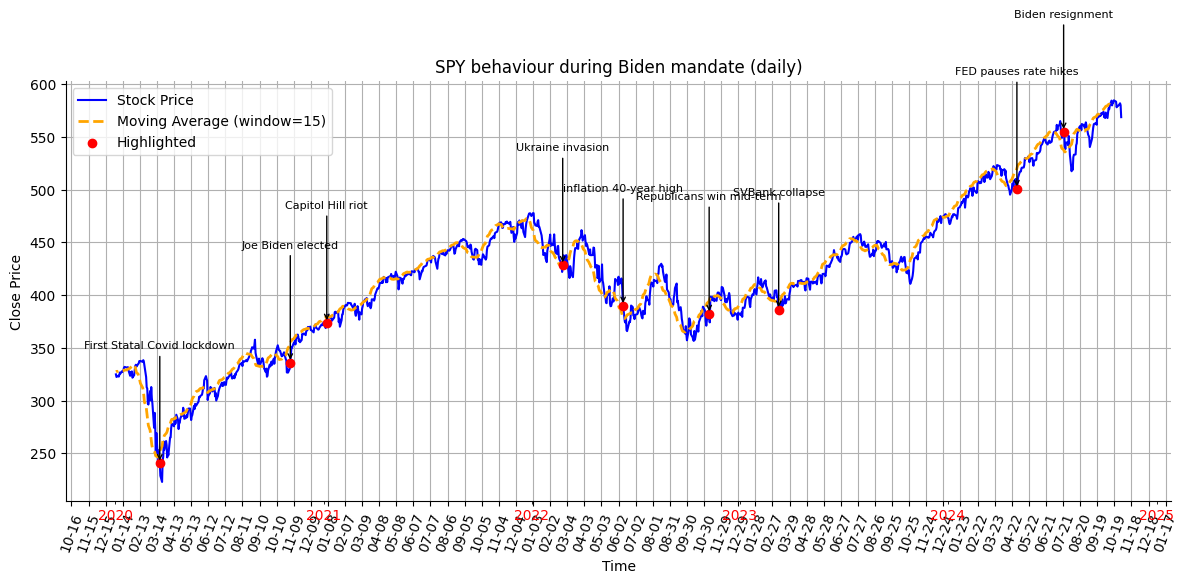

The value of skewness of the dataset is 1.0777814856597865 




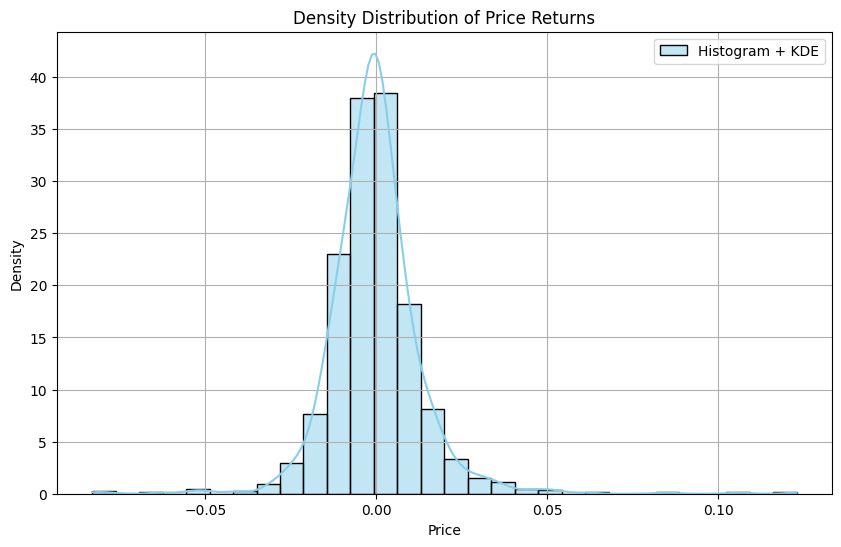

The volatility of prices has been of  70.90665962976243
The volatility of returns has been of  0.01353756583733304

The average volume has been of  82790357.60065736


In [18]:
plot_datas(SP500_biden_d, 'SPY behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)

SP500_biden_d_pct=percentage_return(SP500_biden_d.close)
plot_density_distribution(SP500_biden_d_pct)

SP500_biden_d_volatility = volatility(SP500_biden_d.close)
print('The volatility of prices has been of ',SP500_biden_d_volatility)

SP500_biden_d_volatility_pct = volatility(SP500_biden_d_pct)
print('The volatility of returns has been of ',SP500_biden_d_volatility_pct)

SP500_biden_d_volume = average_volume(SP500_biden_d.volume)
print('\nThe average volume has been of ',SP500_biden_d_volume)

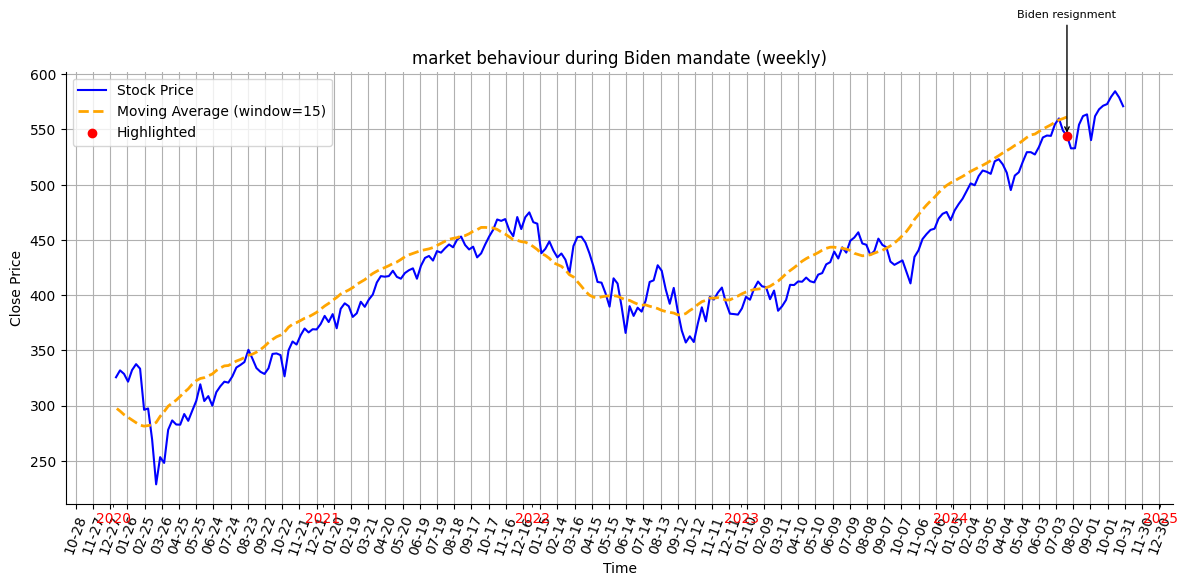

The value of skewness of the dataset is 1.201868811481438 




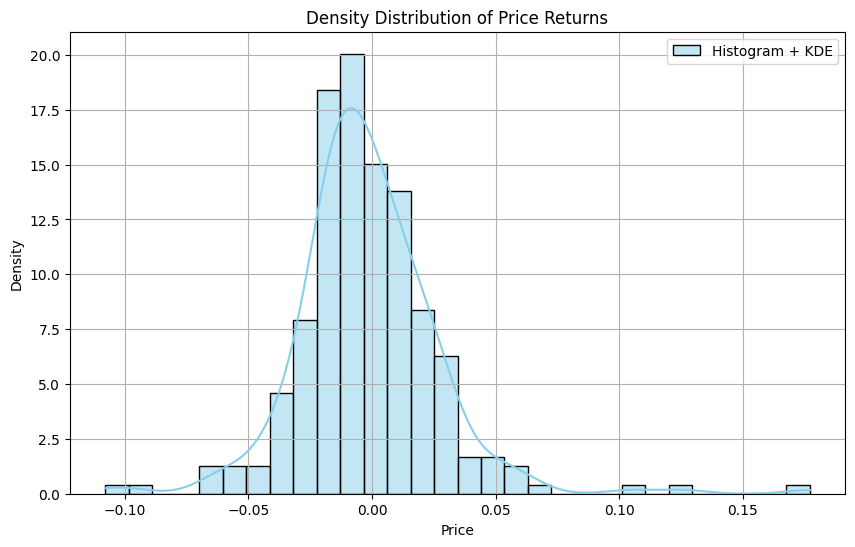

The volatility of prices has been of  71.19656060422322
The volatility of returns has been of  0.02873161060487155

The average volume has been of  399462983.3333333


In [19]:
plot_datas(SP500_biden_w, 'market behaviour during Biden mandate (weekly)','day',30,events,window=15)

SP500_biden_w_pct=percentage_return(SP500_biden_w.close)
plot_density_distribution(SP500_biden_w_pct)

SP500_biden_w_volatility = volatility(SP500_biden_w.close)
print('The volatility of prices has been of ',SP500_biden_w_volatility)

SP500_biden_w_volatility_pct = volatility(SP500_biden_w_pct)
print('The volatility of returns has been of ',SP500_biden_w_volatility_pct)

SP500_biden_w_volume = average_volume(SP500_biden_w.volume)
print('\nThe average volume has been of ',SP500_biden_w_volume)


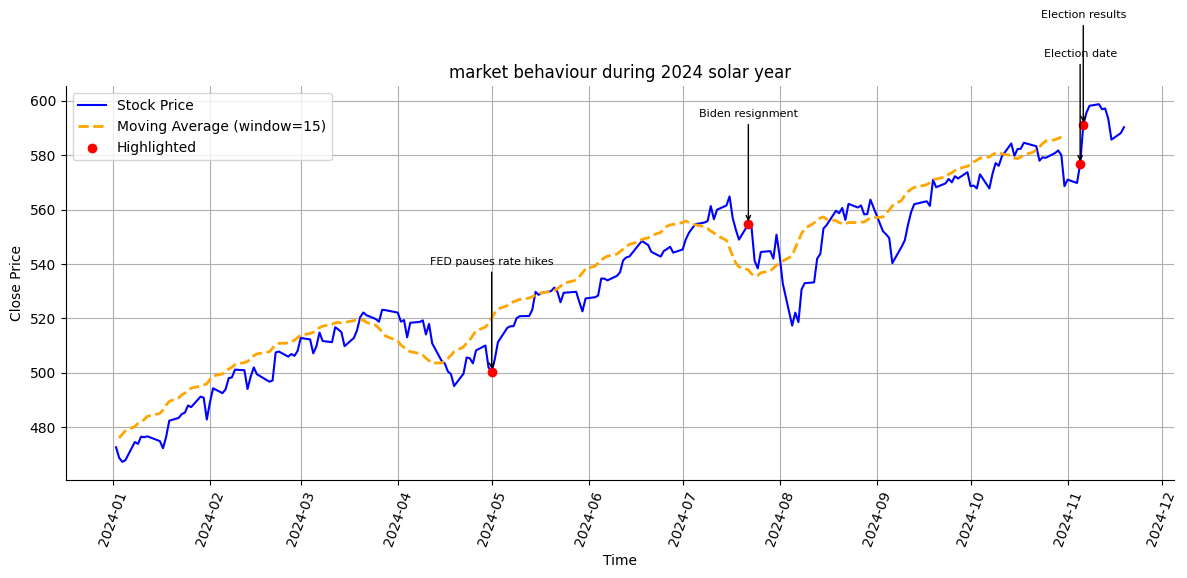

The value of skewness of the dataset is 0.44183398755220116 




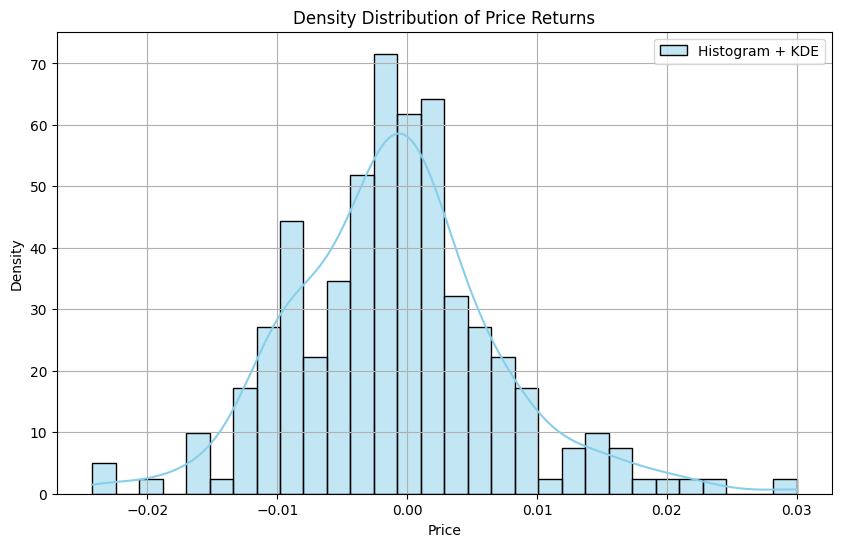

The volatility of prices has been of  32.37429005712021
The volatility of returns has been of  0.007930887277128668

The average volume has been of  58577200.0


In [20]:
plot_datas(SP500_2024, 'market behaviour during 2024 solar year', plotformat='month', interval=1, events=events, window=15)

SP500_2024_pct=percentage_return(SP500_2024.close)
plot_density_distribution(SP500_2024_pct)

SP500_2024_volatility = volatility(SP500_2024.close)
print('The volatility of prices has been of ',SP500_2024_volatility)

SP500_2024_volatility_pct = volatility(SP500_2024_pct)
print('The volatility of returns has been of ',SP500_2024_volatility_pct)

SP500_2024_volume = average_volume(SP500_2024.volume)
print('\nThe average volume has been of ',SP500_2024_volume)

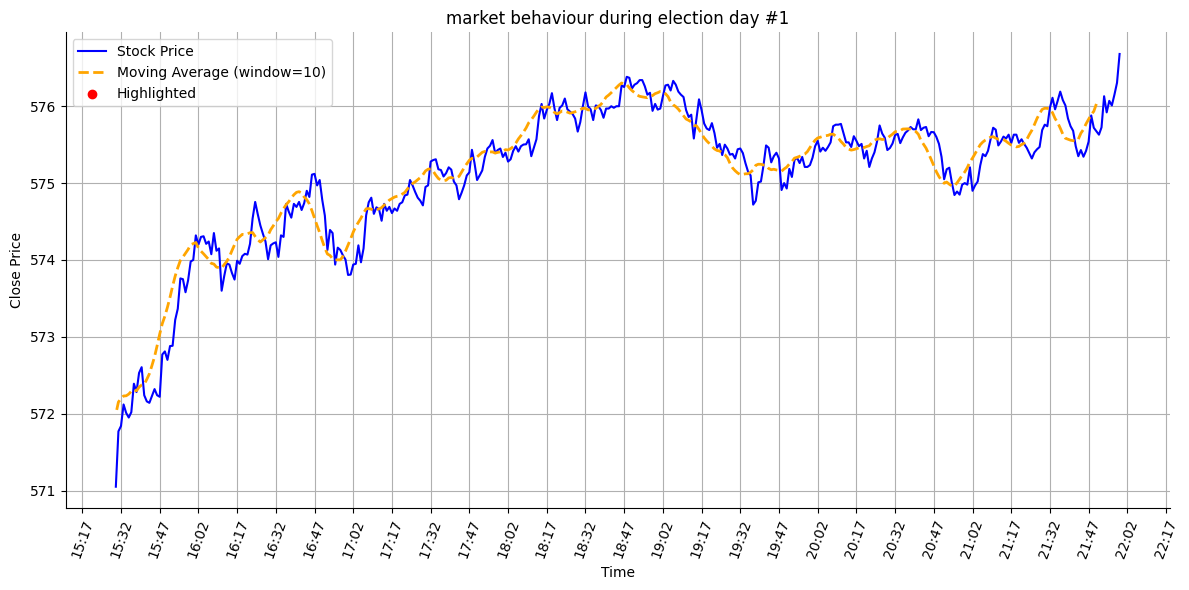

The value of skewness of the dataset is -0.28943592335843166 




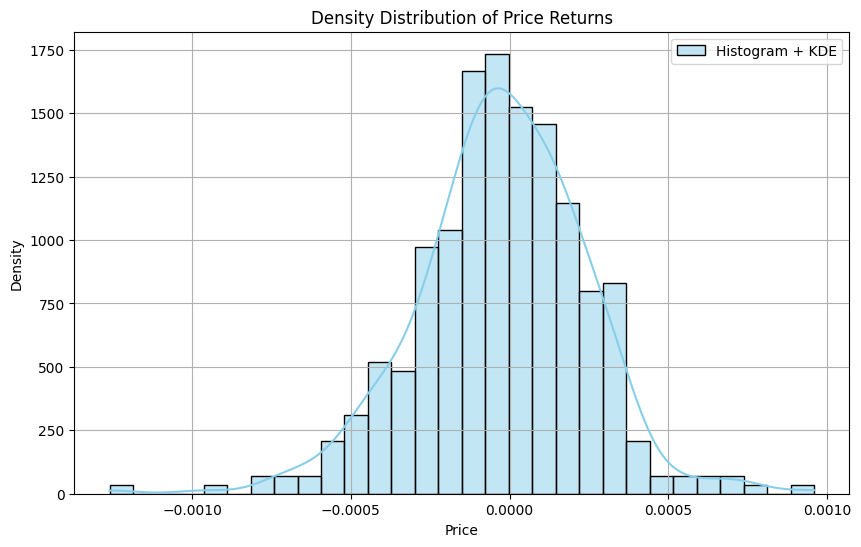

The volatility of prices has been of  0.9656793018477613
The volatility of returns has been of  0.0002674207422105894

The average volume has been of  91159.91282051282


In [21]:
plot_datas(SP500_election_day1, 'market behaviour during election day #1', 'minute', interval=15 , events=events, window=10 )

SP500_election_day1_pct=percentage_return(SP500_election_day1.close)
plot_density_distribution(SP500_election_day1_pct)

SP500_election_day1_volatility = volatility(SP500_election_day1.close)
print('The volatility of prices has been of ',SP500_election_day1_volatility)

SP500_election_day1_volatility_pct = volatility(SP500_election_day1_pct)
print('The volatility of returns has been of ',SP500_election_day1_volatility_pct)

SP500_election_day1_volume = average_volume(SP500_election_day1.volume)
print('\nThe average volume has been of ',SP500_election_day1_volume)


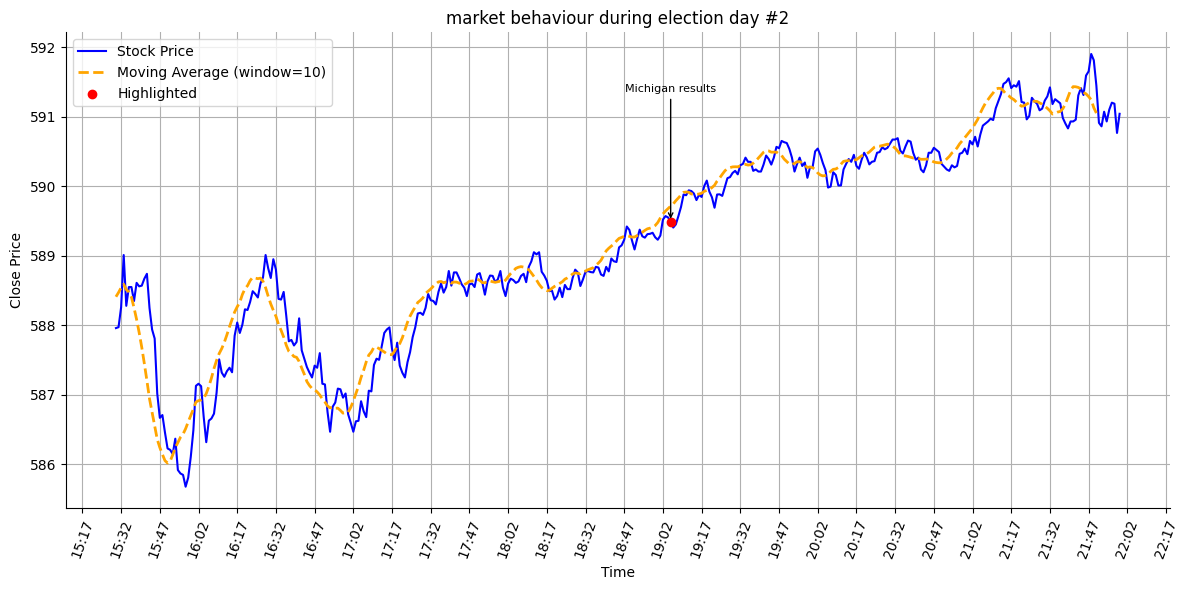

The value of skewness of the dataset is 0.36927633520319314 




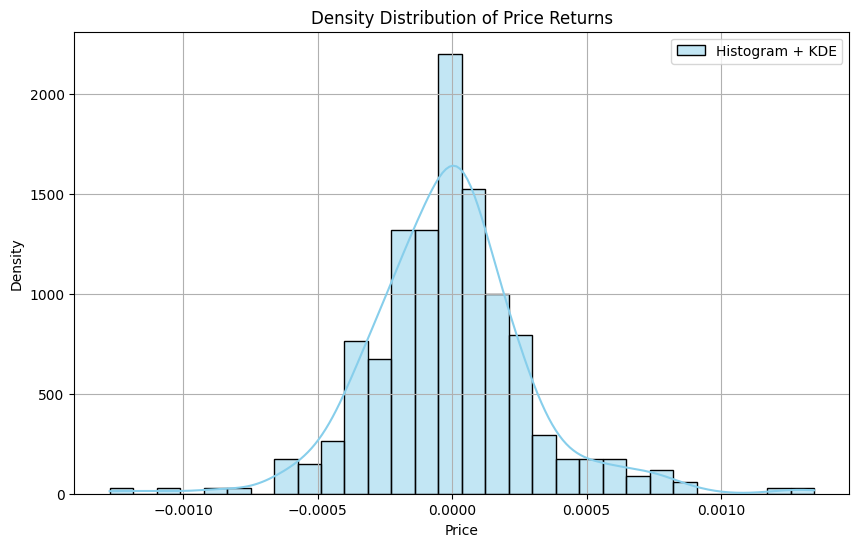

The volatility of prices has been of  1.4519393261752993
The volatility of returns has been of  0.00029690454145238327

The average volume has been of  151743.4358974359


In [22]:
plot_datas(SP500_election_day2, 'market behaviour during election day #2', 'minute', interval=15 , events=events, window=10 )

SP500_election_day2_pct=percentage_return(SP500_election_day2.close)
plot_density_distribution(SP500_election_day2_pct)

SP500_election_day2_volatility = volatility(SP500_election_day2.close)
print('The volatility of prices has been of ',SP500_election_day2_volatility)

SP500_election_day2_volatility_pct = volatility(SP500_election_day2_pct)
print('The volatility of returns has been of ',SP500_election_day2_volatility_pct)

SP500_election_day2_volume = average_volume(SP500_election_day2.volume)
print('\nThe average volume has been of ',SP500_election_day2_volume)

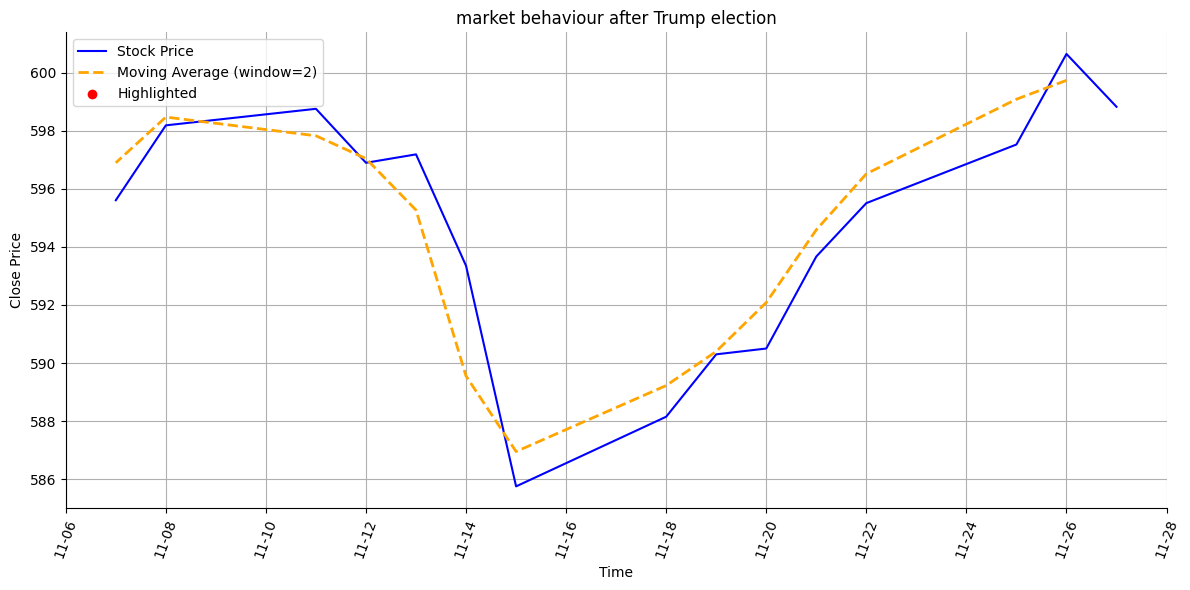

The value of skewness of the dataset is 1.3542181492462226 




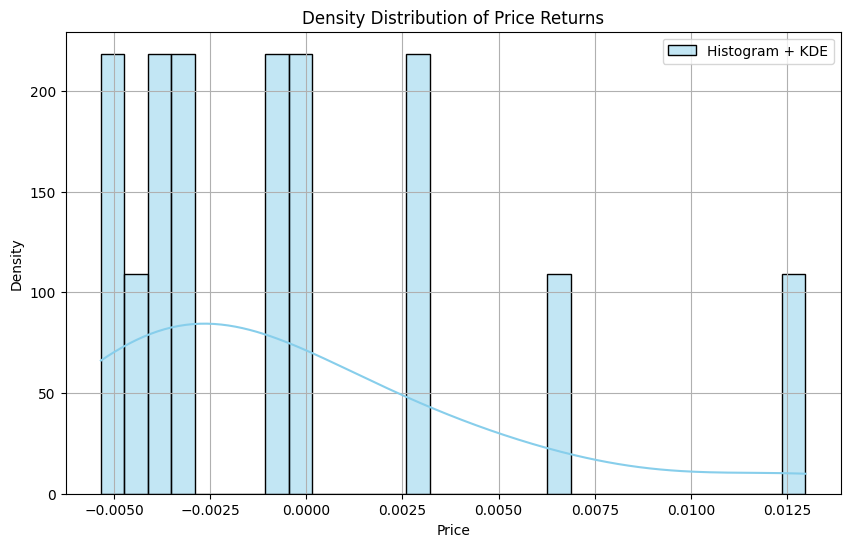

The volatility of prices has been of  4.34688080091735
The volatility of returns has been of  0.005025702007614983

The average volume has been of  45341386.666666664


In [23]:
plot_datas(SP500_aftermath, 'market behaviour after Trump election', plotformat='day', interval=2, events=events , window=2)

SP500_aftermath_pct=percentage_return(SP500_aftermath.close)
plot_density_distribution(SP500_aftermath_pct)

SP500_aftermath_volatility = volatility(SP500_aftermath.close)
print('The volatility of prices has been of ',SP500_aftermath_volatility)

SP500_aftermath_volatility_pct = volatility(SP500_aftermath_pct)
print('The volatility of returns has been of ',SP500_aftermath_volatility_pct)

SP500_aftermath_volume = average_volume(SP500_aftermath.volume)
print('\nThe average volume has been of ',SP500_aftermath_volume)

-----

Let's plot all the cumulated returns and see their behaviour one compared to each other and calculate the correlation matrix to see how the behaviours are correlated together

In [24]:
def plot_versus(title, df1, df2, df3, df4, df5, labels):
    """
    Plots the behavior of 5 ETFs based on their Close prices over a selected time span.

    Args:
        title (str): Title of the plot.
        df1, df2, df3, df4, df5 (pd.DataFrame): DataFrames containing at least 'Close' and 'Date/Time' columns.
        labels (list): A list of labels for the ETFs [label1, label2, ..., label5].
    """
    # Extract data
    etf_data = [
        (df1, labels[0]),
        (df2, labels[1]),
        (df3, labels[2]),
        (df4, labels[3]),
        (df5, labels[4]),
    ]
    
    # Initialize plot
    plt.figure(figsize=(12, 6))
    
    for df, label in etf_data:
        # Ensure the DataFrame is sorted by index (time) in ascending order
        df_sorted = df.sort_index()
        
        # Calculate cumulative returns after computing percentage returns
        cum_ret = calculate_cum_ret(percentage_return(df_sorted['close']))[1:]
        
        # Plot the cumulative returns
        plt.plot(df_sorted.index, cum_ret, label=label, linewidth=2)

    # Title and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    
    # Rotate x-axis labels to improve readability
    plt.xticks(rotation=45)
    
    # Add legend
    plt.legend(loc='best', fontsize=10)
    
    # Add grid for better readability
    plt.grid(alpha=0.3)
    
    # Show plot
    plt.tight_layout()
    plt.show()


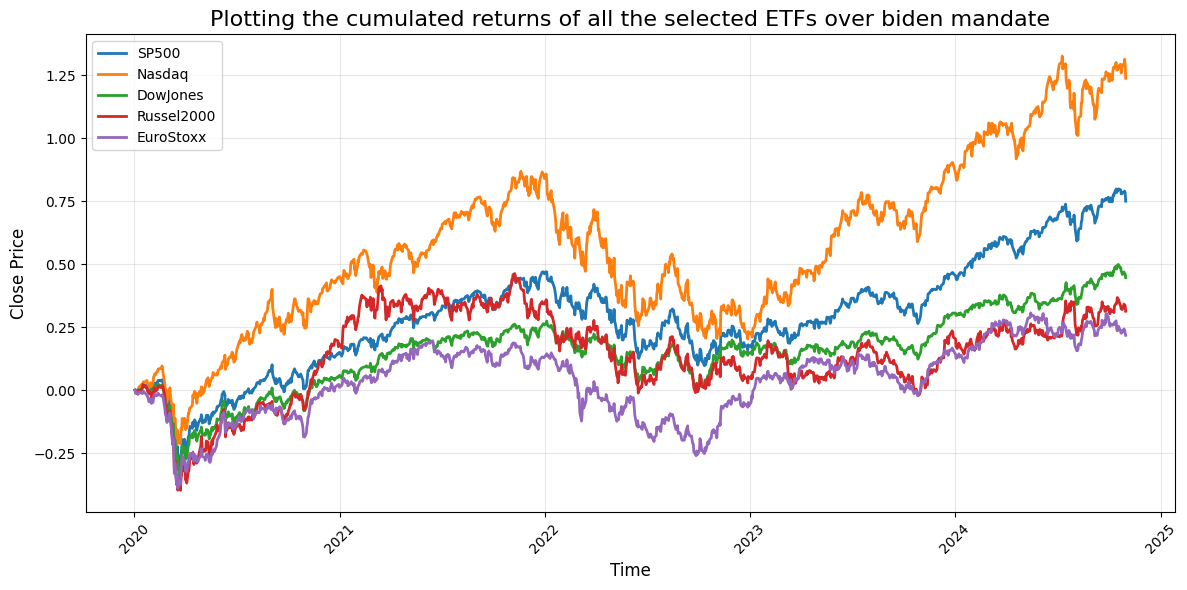

In [25]:
plot_versus('Plotting the cumulated returns of all the selected ETFs over biden mandate', SP500_biden_d, QQQ_biden_d, DIA_biden_d, IWM_biden_d, FEZ_biden_d, INDEXs)

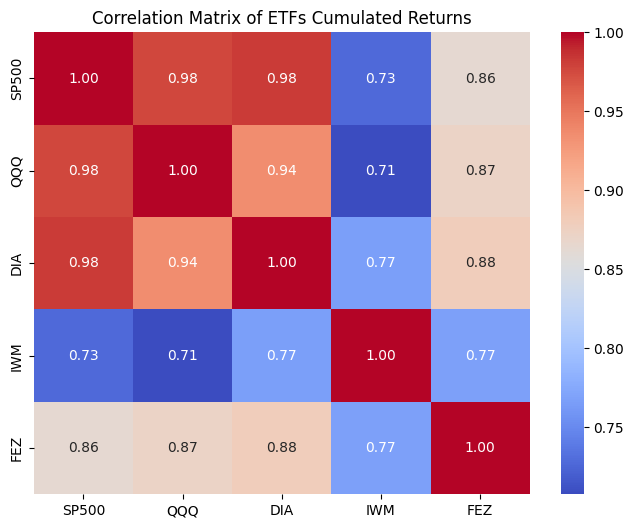

In [26]:
df_matrix = pd.DataFrame()
SP500_cumret = calculate_cum_ret(percentage_return(SP500_biden_d.close))
QQQ_cumret = calculate_cum_ret(percentage_return(QQQ_biden_d.close))
DIA_cumret = calculate_cum_ret(percentage_return(DIA_biden_d.close))
IWM_cumret = calculate_cum_ret(percentage_return(IWM_biden_d.close))
FEZ_cumret = calculate_cum_ret(percentage_return(FEZ_biden_d.close))

df_matrix['SP500']=SP500_cumret
df_matrix['QQQ']=QQQ_cumret
df_matrix['DIA']=DIA_cumret
df_matrix['IWM']=IWM_cumret[:-3]
df_matrix['FEZ']=FEZ_cumret

correlation_matrix(df_matrix)

Now let's plot the datas for the timedelta posterior to the elections

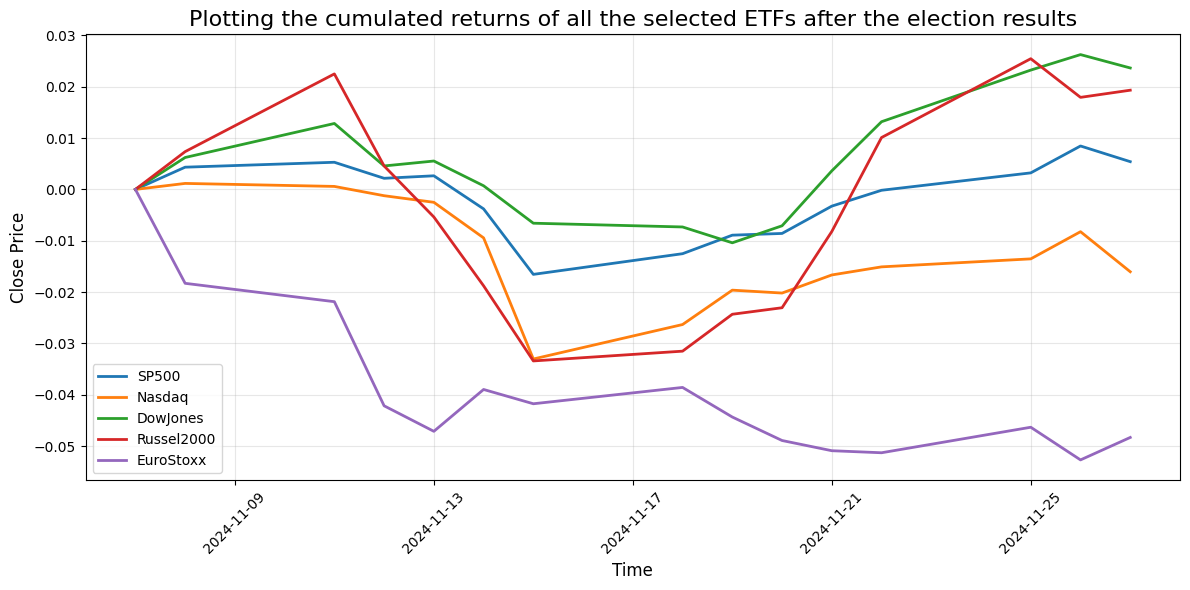

In [27]:
plot_versus('Plotting the cumulated returns of all the selected ETFs after the election results', SP500_aftermath, QQQ_aftermath, DIA_aftermath, IWM_aftermath, FEZ_aftermath, INDEXs)

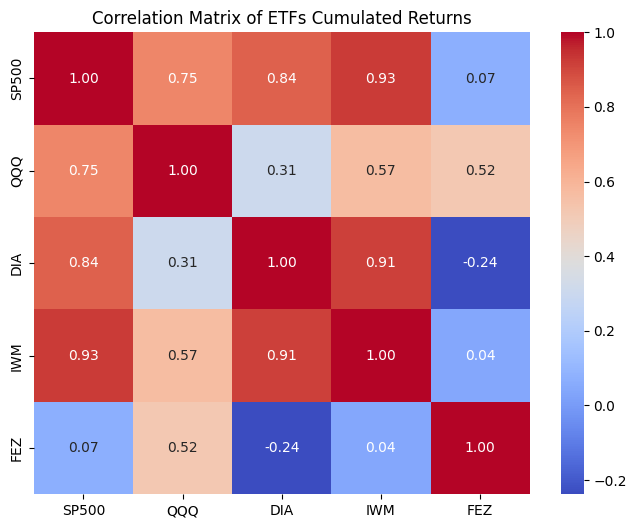

In [28]:
df_matrix_aftermath = pd.DataFrame()
SP500_cumret_aftermath = calculate_cum_ret(percentage_return(SP500_aftermath.close))
QQQ_cumret_aftermath = calculate_cum_ret(percentage_return(QQQ_aftermath.close))
DIA_cumret_aftermath = calculate_cum_ret(percentage_return(DIA_aftermath.close))
IWM_cumret_aftermath = calculate_cum_ret(percentage_return(IWM_aftermath.close))
FEZ_cumret_aftermath = calculate_cum_ret(percentage_return(FEZ_aftermath.close))

df_matrix_aftermath['SP500']=SP500_cumret_aftermath
df_matrix_aftermath['QQQ']=QQQ_cumret_aftermath
df_matrix_aftermath['DIA']=DIA_cumret_aftermath
df_matrix_aftermath['IWM']=IWM_cumret_aftermath
df_matrix_aftermath['FEZ']=FEZ_cumret_aftermath

correlation_matrix(df_matrix_aftermath)

-----

BONUS


Plotting the intraday data for the SP500 ETF with VWAP bands helps identify price movements relative to the average price over time. When the price is above the upper VWAP band, it indicates strong buying pressure, suggesting the asset may be overbought. Conversely, when the price is below the lower band, it signals increased selling pressure, indicating the asset may be oversold. Prices within the bands suggest normal market conditions. These bands provide insights into potential breakouts, overbought/oversold conditions, and price corrections.

In [29]:


def plot_vwap(time, prices, volumes, interval):
    """
    Plots the price and VWAP (Volume Weighted Average Price) of an asset over time,
    along with two sets of VWAP bands that represent volatility based on standard deviations.

    This function calculates the VWAP and two sets of bands around the VWAP based on
    volatility factors, then plots the price, VWAP, and VWAP bands on a time series chart.

    Args:
        time (list or pd.Series): A list or pandas Series containing the time data (timestamps).
        prices (list or pd.Series): A list or pandas Series containing the asset's price data.
        volumes (list or pd.Series): A list or pandas Series containing the asset's volume data.
        interval (int): The interval (in minutes) used to set the time axis tick spacing.

    Returns:
        None: The function plots the time series of the price, VWAP, and the associated VWAP bands.
        """
    cumulative_price_volume = 0
    cumulative_volume = 0
    vwap_values = []
    volatility_factors=[]
    for i in range(len(prices)):
        volatility_factors.append(volatility(prices[:i + 1]))

    for price, volume in zip(prices, volumes):
        cumulative_price_volume += price * volume
        cumulative_volume += volume
        if cumulative_volume == 0:
            vwap_values.append(None)  # Avoid division by zero
        else:
            vwap_values.append(cumulative_price_volume / cumulative_volume)
    
    # Create VWAP Bands
    upper_band_1 = [vwap + (1 * vol) for vwap, vol in zip(vwap_values, volatility_factors)]
    lower_band_1 = [vwap - (1 * vol) for vwap, vol in zip(vwap_values, volatility_factors)]
    
    upper_band_2 = [vwap + (1.5 * vol) for vwap, vol in zip(vwap_values, volatility_factors)]
    lower_band_2 = [vwap - (1.5 * vol) for vwap, vol in zip(vwap_values, volatility_factors)]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set the x-axis locator and formatter for time intervals
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Plot Price and VWAP
    ax.plot(time, prices, color='red', label='Price', linewidth=2)
    ax.plot(time, vwap_values, color='blue', label='VWAP', linewidth=2)
    
    # Plot the first set of bands
    ax.fill_between(
        time, lower_band_1, upper_band_1, 
        color='lightgreen', alpha=0.4, label='VWAP Bands (±1σ)'
    )
    
    # Plot the second set of bands
    ax.fill_between(
        time, lower_band_2, upper_band_2, 
        color='lightblue', alpha=0.3, label='VWAP Bands (±1.5σ)'
    )

    # Title and labels
    ax.set_title('Price vs VWAP with Bands')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price / VWAP')
    
    # Rotate x-axis labels to make them readable
    plt.xticks(rotation=45)
    
    # Show the legend
    ax.legend()
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

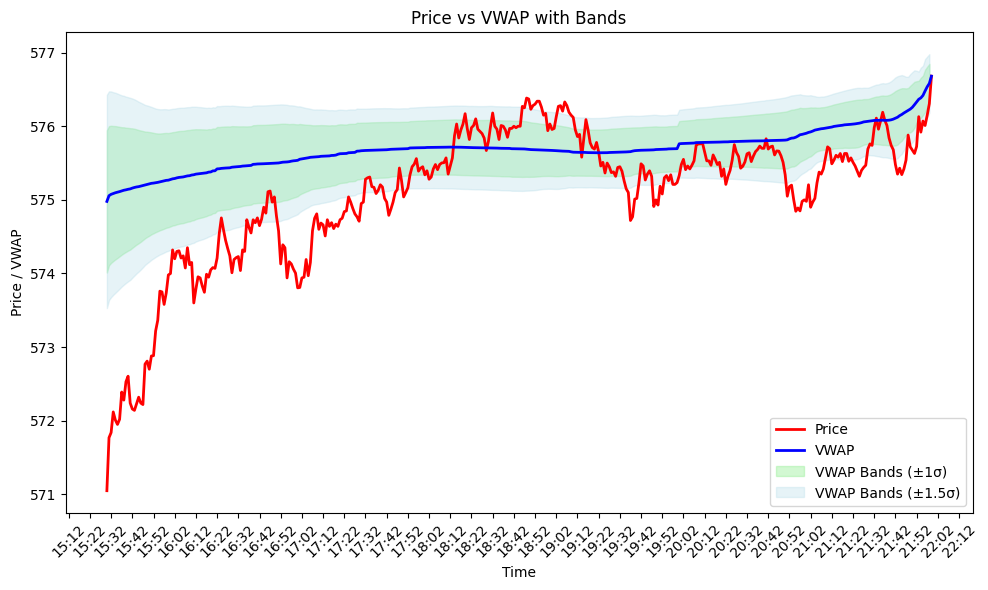

In [30]:
plot_vwap(SP500_election_day1.index, SP500_election_day1.close, SP500_election_day1.volume, 10)

-------